In [20]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# Parameters for the Genetic Algorithm
POPULATION_SIZE = 50
NUM_GENERATIONS = 20
CROSSOVER_RATE = 0.7
MUTATION_RATE = 0.1

In [23]:
# Load the subset dataset
subset_path = '/kaggle/input/courses-scheduling/genetic_algorithm_course_scheduling_subset.xlsx'
subset_df = pd.read_excel(subset_path)


In [24]:
# Step 1: Initialize Population
def initialize_population(df, population_size=POPULATION_SIZE):
    course_ids = df['Course_ID'].values
    course_preferences = df.set_index('Course_ID')[['Preferred_Days', 'Preferred_Times']].to_dict('index')
    
    population = []
    for _ in range(population_size):
        chromosome = {course_id: (random.choice(course_preferences[course_id]['Preferred_Days'].split(',')),
                                  random.choice(course_preferences[course_id]['Preferred_Times'].split(',')))
                      for course_id in course_ids}
        population.append(chromosome)
    return population

In [25]:
# Step 2: Fitness Function
def calculate_fitness(chromosome, df):
    fitness = 0
    course_preferences = df.set_index('Course_ID')[['Preferred_Days', 'Preferred_Times', 'Prerequisites']].to_dict('index')
    
    for course_id, (assigned_day, assigned_time) in chromosome.items():
        prefs = course_preferences[course_id]
        
        # Reward for preferred day and time
        if assigned_day == prefs['Preferred_Days']:
            fitness += 10
        if assigned_time == prefs['Preferred_Times']:
            fitness += 10

        # Check prerequisites
        prereq_id = prefs['Prerequisites']
        if prereq_id != "None" and prereq_id in chromosome and chromosome[prereq_id] < (assigned_day, assigned_time):
            fitness += 20
            
    return fitness


In [26]:
# Step 3: Selection Function
def select_parents(population, fitness_scores, num_parents=2):
    total_fitness = sum(fitness_scores)
    selection_probs = [fitness / total_fitness for fitness in fitness_scores]
    parents = random.choices(population, weights=selection_probs, k=num_parents)
    return parents


In [27]:
# Step 4: Crossover
def crossover(parent1, parent2):
    child = parent1.copy()
    if random.random() < CROSSOVER_RATE:
        crossover_point = random.randint(0, len(parent1)-1)
        keys = list(parent1.keys())
        for i in range(crossover_point, len(keys)):
            key = keys[i]
            child[key] = parent2[key]
    return child


In [28]:
# Step 5: Mutation
def mutate(chromosome):
    if random.random() < MUTATION_RATE:
        course_id = random.choice(list(chromosome.keys()))
        chromosome[course_id] = (random.choice(["Mon", "Tue", "Wed", "Thu", "Fri"]),
                                 random.choice(["Morning", "Afternoon", "Evening"]))
    return chromosome

In [31]:
# Step 6: Main GA Loop
def genetic_algorithm(df, num_generations=NUM_GENERATIONS):
    population = initialize_population(df)
    best_solution = None
    best_fitness = -float('inf')
    
    for generation in range(num_generations):
        fitness_scores = [calculate_fitness(chromosome, df) for chromosome in population]
        
        # Track the best solution in the current generation
        max_fitness = max(fitness_scores)
        current_best_solution = population[fitness_scores.index(max_fitness)]
        
        # Update overall best solution if the current generation has a better one
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_solution = current_best_solution
        
        # Print current generation details
        print(f"Generation {generation + 1}:")
        print(f"Best Fitness Score: {max_fitness}")
        print(f"Best Solution: {current_best_solution}")
        print("-" * 50)
        
        # Selection, Crossover, and Mutation
        new_population = []
        for _ in range(POPULATION_SIZE // 2):
            parent1, parent2 = select_parents(population, fitness_scores)
            child1, child2 = crossover(parent1, parent2), crossover(parent2, parent1)
            new_population.extend([mutate(child1), mutate(child2)])
        
        population = new_population  # Update population
    
    print("\nFinal Best Schedule:")
    print(f"Best Fitness Score: {best_fitness}")
    print("Best Solution (Final Schedule):")
    for course_id, schedule in best_solution.items():
        print(f"Course {course_id}: Day - {schedule[0]}, Time - {schedule[1]}")
    
    return best_solution, best_fitness

# Execute the GA and retrieve the best schedule
best_schedule, best_score = genetic_algorithm(subset_df)


Generation 1:
Best Fitness Score: 2080
Best Solution: {'C0522': ('Tue', 'Morning'), 'C0738': ('Tue', 'Afternoon'), 'C0741': ('Tue', 'Morning'), 'C0661': ('Mon', 'Evening'), 'C0412': ('Mon', 'Afternoon'), 'C0679': ('Thu', 'Morning'), 'C0627': ('Tue', 'Evening'), 'C0514': ('Tue', 'Morning'), 'C0860': ('Mon', 'Evening'), 'C0137': ('Thu', 'Evening'), 'C0812': ('Wed', 'Evening'), 'C0077': ('Mon', 'Morning'), 'C0637': ('Fri', 'Afternoon'), 'C0974': ('Wed', 'Morning'), 'C0939': ('Tue', 'Morning'), 'C0900': ('Wed', 'Morning'), 'C0281': ('Mon', 'Afternoon'), 'C0884': ('Thu', 'Morning'), 'C0762': ('Fri', 'Afternoon'), 'C0320': ('Thu', 'Morning'), 'C0550': ('Thu', 'Evening'), 'C0175': ('Fri', 'Evening'), 'C0372': ('Mon', 'Evening'), 'C0528': ('Wed', 'Morning'), 'C0211': ('Tue', 'Evening'), 'C0236': ('Mon', 'Evening'), 'C0102': ('Thu', 'Afternoon'), 'C0987': ('Tue', 'Evening'), 'C0903': ('Tue', 'Morning'), 'C0948': ('Wed', 'Afternoon'), 'C0347': ('Fri', 'Afternoon'), 'C0140': ('Wed', 'Morning'), '

/tmp/ipykernel_30/3654232084.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(schedule))


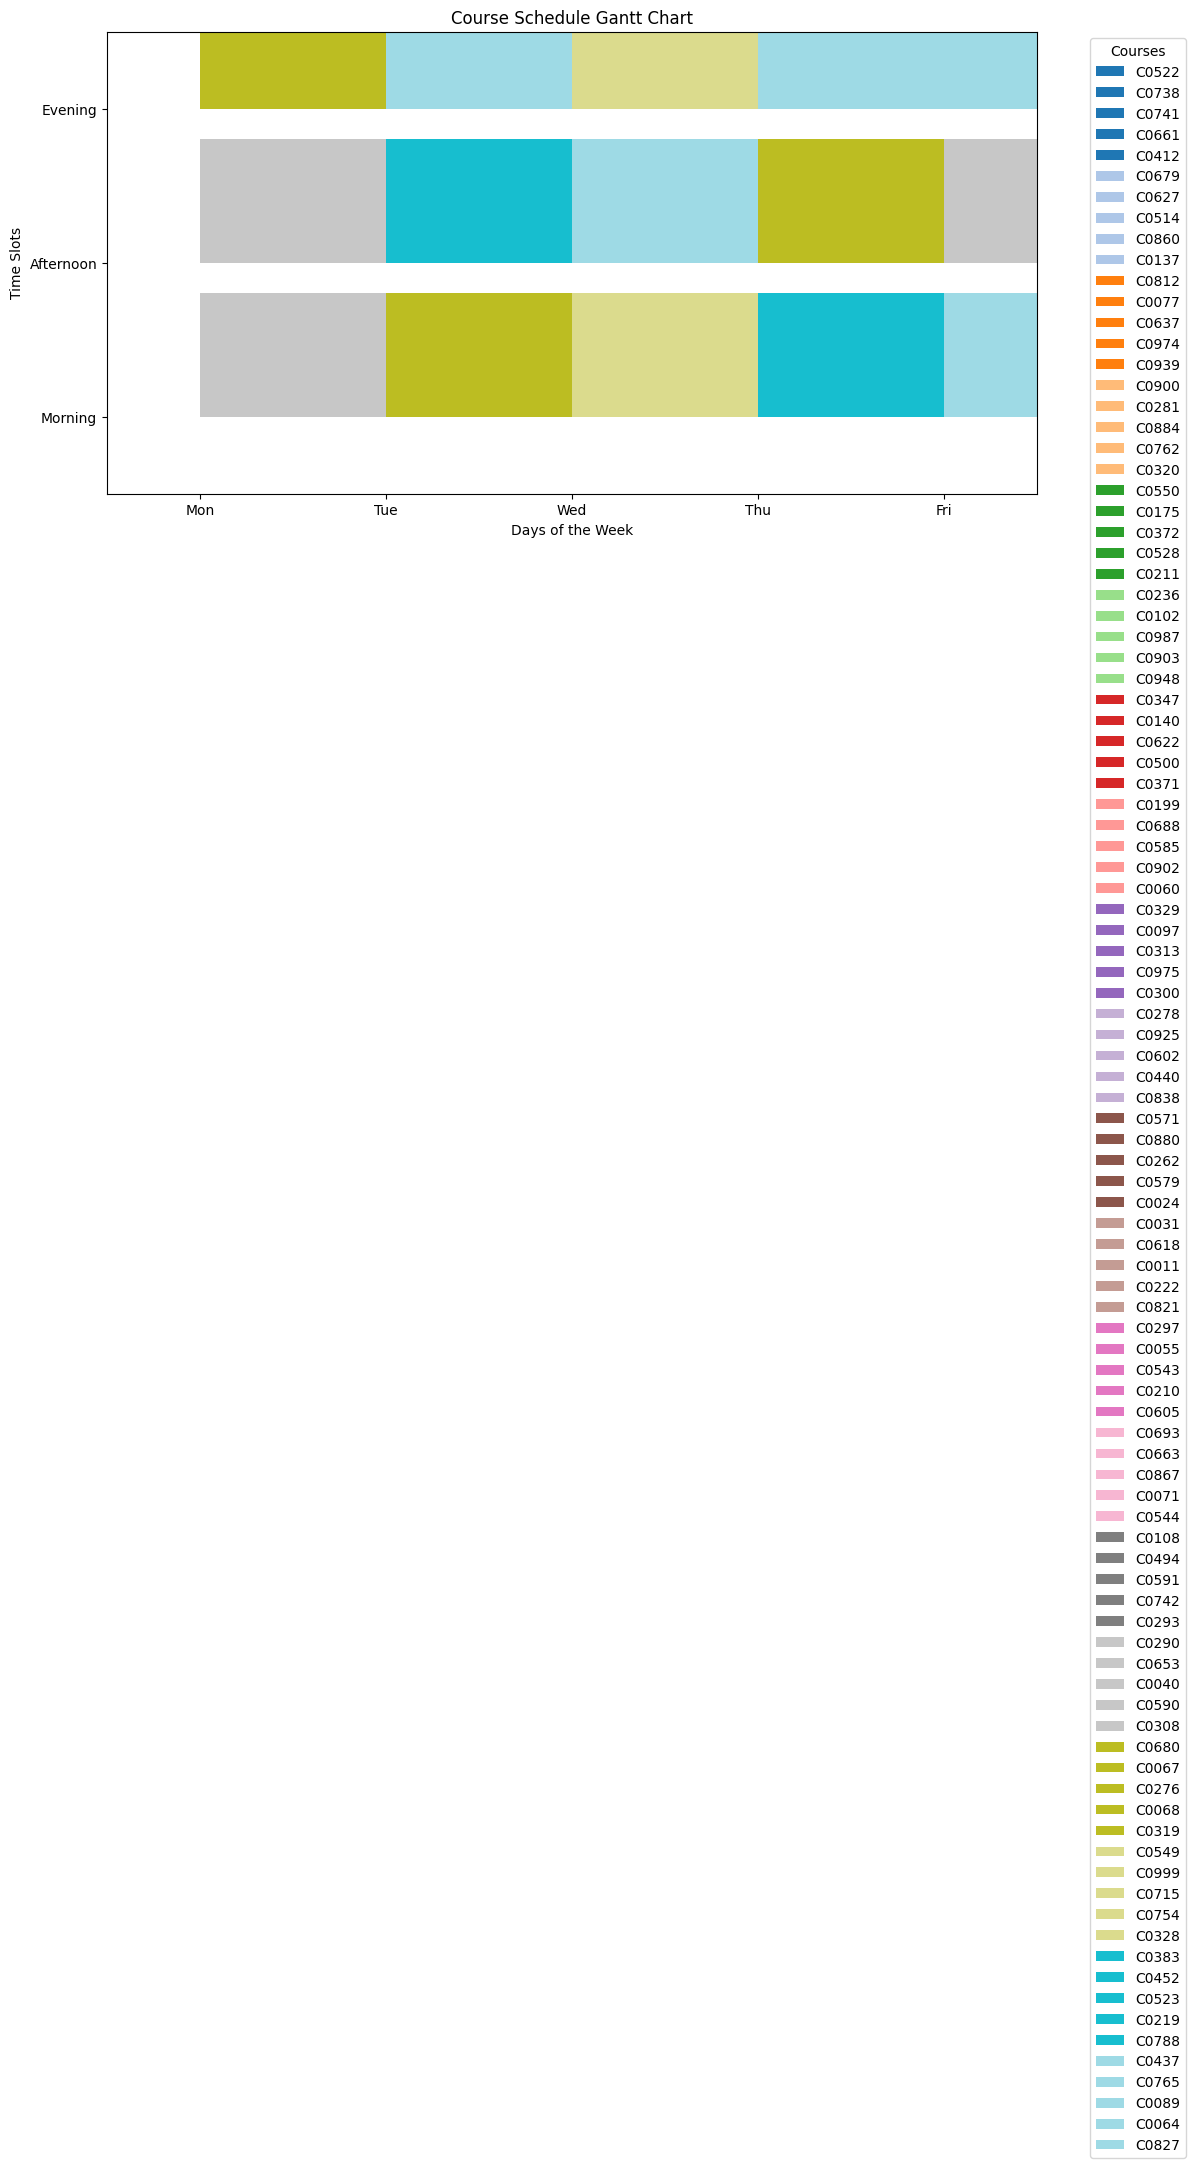

In [30]:
# Step 7: Plotting function to visualize the best schedule with a Gantt chart
def plot_gantt_chart(schedule):
    time_mapping = {"Morning": 0, "Afternoon": 1, "Evening": 2}
    day_mapping = {"Mon": 0, "Tue": 1, "Wed": 2, "Thu": 3, "Fri": 4}
    colors = plt.cm.get_cmap("tab20", len(schedule))

    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot each course in the schedule
    for i, (course_id, (day, time)) in enumerate(schedule.items()):
        x_start = day_mapping[day]
        y_start = time_mapping[time]
        ax.broken_barh([(x_start, 1)], (y_start, 0.8), facecolors=colors(i), label=course_id)
    
    # Customizing the Gantt chart
    ax.set_xticks(range(len(day_mapping)), labels=day_mapping.keys())
    ax.set_yticks(range(len(time_mapping)), labels=time_mapping.keys())
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_xlabel("Days of the Week")
    ax.set_ylabel("Time Slots")
    ax.set_title("Course Schedule Gantt Chart")
    ax.legend(title="Courses", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# Plot the best schedule
plot_gantt_chart(best_schedule)

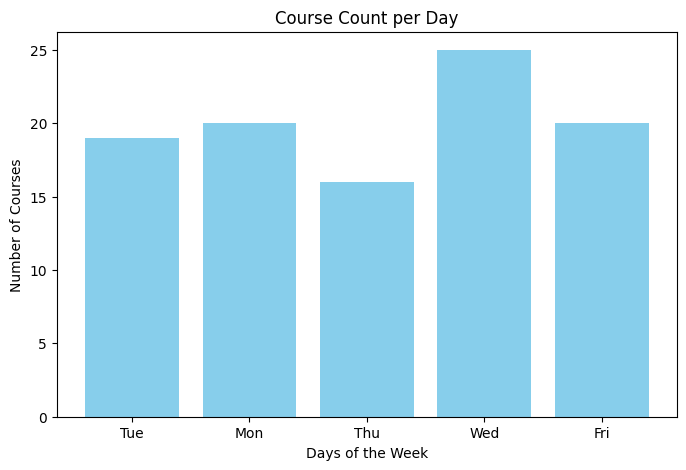

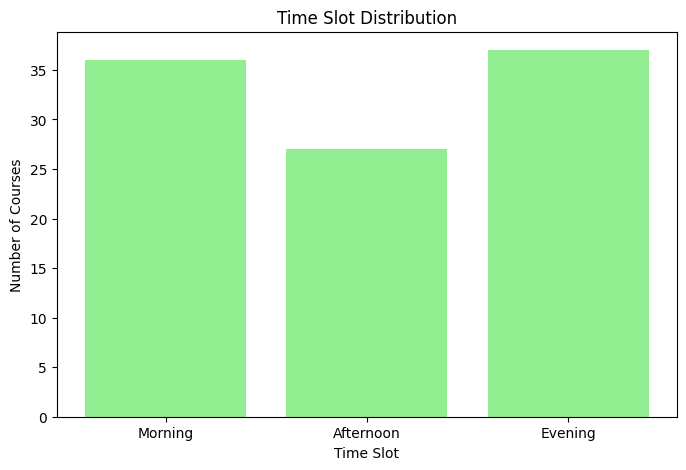

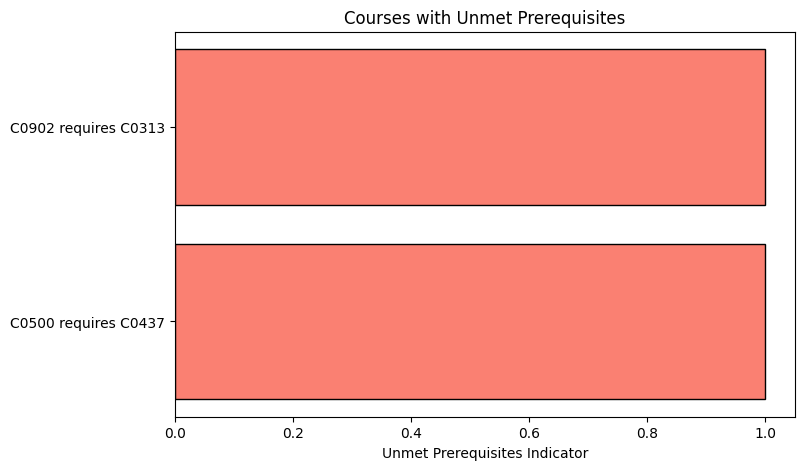

In [32]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to visualize the schedule in multiple ways
def visualize_schedule_analysis(schedule, df):
    # Load course preferences and prerequisites
    course_preferences = df.set_index('Course_ID')[['Preferred_Days', 'Preferred_Times', 'Prerequisites']].to_dict('index')
    
    # Extract day and time distribution data
    days = [schedule[course_id][0] for course_id in schedule.keys()]
    times = [schedule[course_id][1] for course_id in schedule.keys()]
    
    # 1. Course Count per Day
    day_distribution = Counter(days)
    plt.figure(figsize=(8, 5))
    plt.bar(day_distribution.keys(), day_distribution.values(), color='skyblue')
    plt.xlabel("Days of the Week")
    plt.ylabel("Number of Courses")
    plt.title("Course Count per Day")
    plt.show()

    # 2. Time Slot Distribution
    time_slot_distribution = Counter(times)
    plt.figure(figsize=(8, 5))
    plt.bar(time_slot_distribution.keys(), time_slot_distribution.values(), color='lightgreen')
    plt.xlabel("Time Slot")
    plt.ylabel("Number of Courses")
    plt.title("Time Slot Distribution")
    plt.show()

    # 3. Unmet Prerequisites Visualization
    unmet_prerequisites = []
    for course_id, (assigned_day, assigned_time) in schedule.items():
        prereq_id = course_preferences[course_id]['Prerequisites']
        if prereq_id != "None" and prereq_id in schedule:
            prereq_day, prereq_time = schedule[prereq_id]
            if (prereq_day, prereq_time) >= (assigned_day, assigned_time):
                unmet_prerequisites.append((course_id, prereq_id))
    
    # Display unmet prerequisites if any
    if unmet_prerequisites:
        courses, prerequisites = zip(*unmet_prerequisites)
        plt.figure(figsize=(8, 5))
        plt.barh(courses, [1]*len(courses), color='salmon', edgecolor='black')
        plt.xlabel("Unmet Prerequisites Indicator")
        plt.title("Courses with Unmet Prerequisites")
        plt.yticks(courses, [f"{course} requires {prereq}" for course, prereq in unmet_prerequisites])
        plt.show()
    else:
        print("All prerequisites are met in the schedule.")

# Generate visualizations for the best schedule
visualize_schedule_analysis(best_schedule, subset_df)
